In [1]:
## Import Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import math
from scipy.stats import norm, skew
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data Visualization

## Gathering Data

In [4]:
inputPath = "./pp-complete.csv"
cols = ["price", "purchase date", "property type", "old/new", "lease duration", "town/city"]
df = pd.read_csv(inputPath, sep=",", header=0, names=cols, usecols=[1, 2, 4, 5, 6, 11])

In [5]:
df.shape 

(25744779, 6)

In [8]:
id = np.array(range(0,25744779))

In [11]:
df = df.assign(ID=id)

In [12]:
df.head()

,price,purchase date,property type,old/new,lease duration,town/city,ID
0,73450,1995-10-09 00:00,D,Y,F,LIVERPOOL,0
1,59000,1995-03-31 00:00,D,N,F,POOLE,1
2,31000,1995-12-04 00:00,D,Y,F,WOODBRIDGE,2
3,95000,1995-09-22 00:00,D,N,F,LICHFIELD,3
4,45450,1995-02-28 00:00,S,Y,F,CHESTERFIELD,4


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25744779 entries, 0 to 25744778
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   price           int64 
 1   purchase date   object
 2   property type   object
 3   old/new         object
 4   lease duration  object
 5   town/city       object
 6   ID              int64 
dtypes: int64(2), object(5)
memory usage: 1.3+ GB


In [14]:
# Figuring out index of 2019 for separation later
df.iloc[24162100:24162110]

,price,purchase date,property type,old/new,lease duration,town/city,ID
24162100,139950,2018-06-29 00:00,T,Y,F,HEBBURN,24162100
24162101,100000,2018-11-16 00:00,T,N,F,HOUGHTON LE SPRING,24162101
24162102,334950,2018-11-30 00:00,D,Y,F,HEBBURN,24162102
24162103,106010,2018-12-12 00:00,F,N,L,NEWCASTLE UPON TYNE,24162103
24162104,144995,2018-07-26 00:00,T,Y,F,NEWCASTLE UPON TYNE,24162104
24162105,334950,2018-07-13 00:00,D,Y,F,NEWCASTLE UPON TYNE,24162105
24162106,201000,2019-06-07 00:00,S,N,F,NOTTINGHAM,24162106
24162107,81500,2019-06-21 00:00,S,N,F,ALFRETON,24162107
24162108,85000,2019-05-24 00:00,T,N,F,CHESTERFIELD,24162108
24162109,145000,2019-05-10 00:00,S,N,F,NOTTINGHAM,24162109


24162106

## Target Anaysis

In [15]:
# Our target column is the price column
print(df['price'].describe())

count    2.574478e+07
mean     2.013365e+05
std      8.028588e+05
min      1.000000e+00
25%      8.000000e+04
50%      1.400000e+05
75%      2.300000e+05
max      5.943000e+08
Name: price, dtype: float64


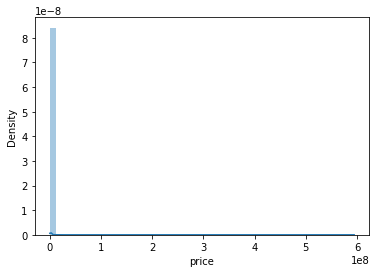

In [16]:
 sns.distplot(df['price'])

In [17]:
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

Skewness: 202.045555
Kurtosis: 75617.765196


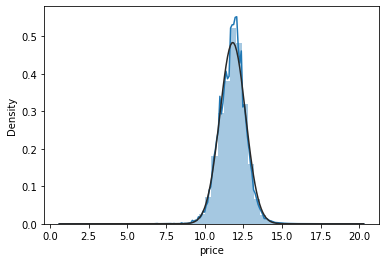

In [18]:
# fixing the skew

df['price'] = np.log1p(df['price'])
sns.distplot(df['price'], fit=norm);

## Feature Analysis (not very useful in this case)
### Useful if we have a lot of features

In [19]:
df['purchase date']=df['purchase date'].astype('category').cat.codes
df['property type']=df['property type'].astype('category').cat.codes
df['old/new']=df['old/new'].astype('category').cat.codes
df['lease duration']=df['lease duration'].astype('category').cat.codes
df['town/city']=df['town/city'].astype('category').cat.codes

df.corr()

,price,purchase date,property type,old/new,lease duration,town/city,ID
price,1.000000,0.528574,-0.291002,0.070042,-0.069007,0.011020,0.541696
purchase date,0.528574,1.000000,-0.027187,0.000032,0.026727,-0.000989,0.994705
property type,-0.291002,-0.027187,1.000000,-0.154801,-0.256689,-0.020311,-0.025293
old/new,0.070042,0.000032,-0.154801,1.000000,0.109640,-0.001830,-0.002011
lease duration,-0.069007,0.026727,-0.256689,0.109640,1.000000,0.012926,0.029397
town/city,0.011020,-0.000989,-0.020311,-0.001830,0.012926,1.000000,-0.001143
ID,0.541696,0.994705,-0.025293,-0.002011,0.029397,-0.001143,1.000000


In [20]:
df.iloc[24162100:24162110]

,price,purchase date,property type,old/new,lease duration,town/city,ID
24162100,11.849048,8579,4,1,0,462,24162100
24162101,11.512935,8719,4,0,0,502,24162101
24162102,12.721740,8733,0,1,0,462,24162102
24162103,11.571298,8745,1,0,1,720,24162103
24162104,11.884461,8606,4,1,0,720,24162104
24162105,12.721740,8593,0,1,0,720,24162105
24162106,12.211065,8922,3,0,0,744,24162106
24162107,11.308371,8936,3,0,0,16,24162107
24162108,11.350418,8908,4,0,0,243,24162108
24162109,11.884496,8894,3,0,0,744,24162109


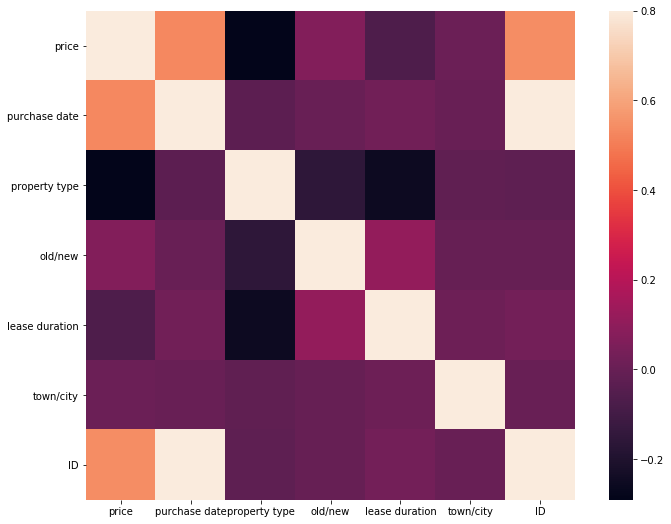

In [21]:
# What are most important features that affect house prices

corrMatrix = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrMatrix, vmax=.8, square=True);

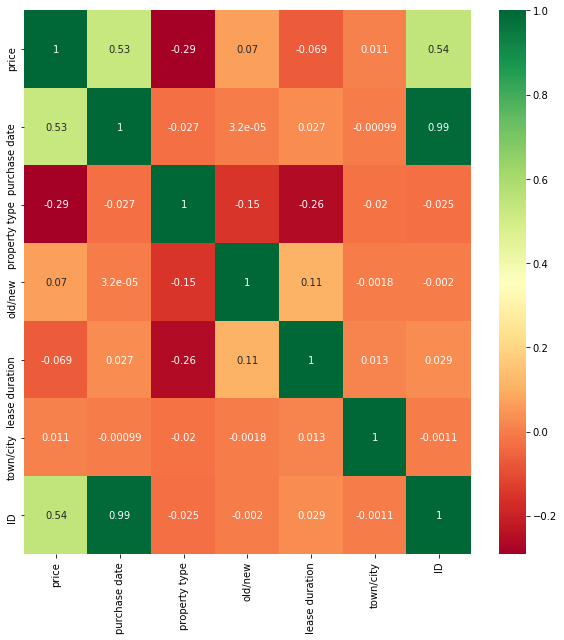

In [22]:
corr = df.corr()
highest_corr_features = corr.index[abs(corr["price"]) > 0.0]
plt.figure(figsize=(10,10))
g = sns.heatmap(df[highest_corr_features].corr(),annot=True,cmap="RdYlGn")

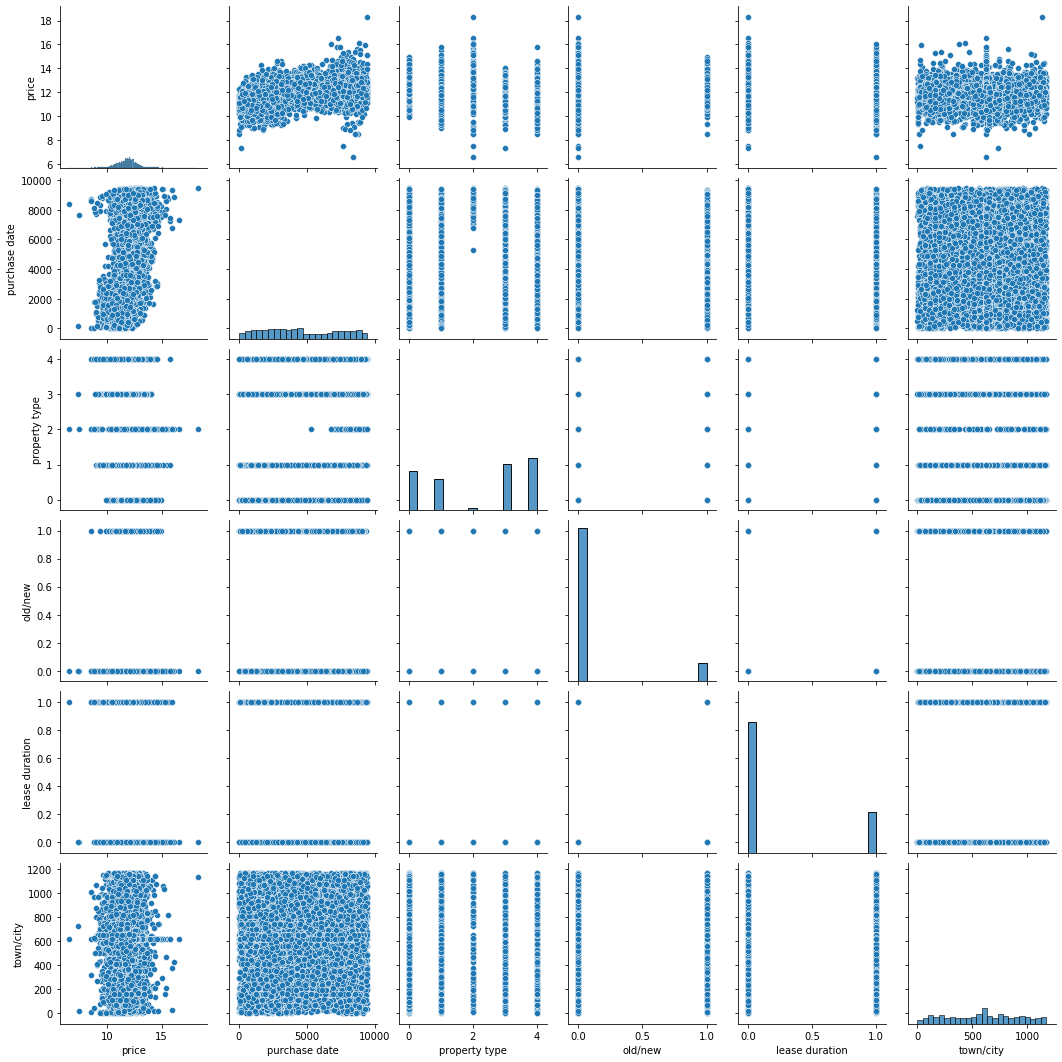

In [23]:
# Pair Grid of features
sns.pairplot(df[cols].sample(10000))

Now, We explored the data and know the important features.

## Looking for missing data

In [24]:
Total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([Total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
ID,0,0.0
town/city,0,0.0
lease duration,0,0.0
old/new,0,0.0
property type,0,0.0
purchase date,0,0.0
price,0,0.0


Good we have no missing data!

# Feature Engineering

In [25]:
# Fix the skewness in other features
features = df.dtypes[df.dtypes != 'object'].index
skewed_features = df[features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
high_skew

old/new           2.580916
lease duration    1.243142
dtype: float64

In [26]:
for feature in high_skew.index:
    df[feature] = np.log1p(df[feature])

In [27]:
# Conveting categorical data to numerical

df = pd.get_dummies(df)
df.head()

,price,purchase date,property type,old/new,lease duration,town/city,ID
0,11.204374,281,0,0.693359,0.0,583,0
1,10.985310,89,0,0.000000,0.0,793,1
2,10.341775,337,0,0.693359,0.0,1148,2
3,11.461643,264,0,0.000000,0.0,573,3
4,10.724390,58,3,0.693359,0.0,243,4


# Separating data

In [28]:
df_train = df.iloc[:24162106, :]
df_test = df.iloc[24162106:, :]

In [29]:
df_train.shape, df_test.shape

((24162106, 7), (1582673, 7))

In [30]:
x_train = df_train.drop(['ID', 'price'], axis=1)
y_train = df_train['price']

In [31]:
x_train.shape, y_train.shape

((24162106, 5), (24162106,))

In [33]:
x_test = df_test.drop(['ID', 'price'], axis=1)
y_test = df_test['price']
test_id = df_test['ID']

In [34]:
x_test.shape, y_test.shape

((1582673, 5), (1582673,))

# ML Model

In [35]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

In [36]:
import xgboost as XGB

model = XGB.XGBRegressor()
model.fit(x_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [37]:
import pickle
filename = 'final_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [38]:
y_pred = np.floor(np.expm1(model.predict(x_test)))
y_pred

array([231391., 205992.,  93958., ..., 335408.,  94384., 155072.],
      dtype=float32)

In [53]:
y_test = df_test['price']
y_test.head()

24162106    12.211065
24162107    11.308371
24162108    11.350418
24162109    11.884496
24162110    11.338584
Name: price, dtype: float64

In [54]:
y_test = np.floor(np.expm1(y_test))

In [55]:
y_test.head()

24162106    200999.0
24162107     81499.0
24162108     84999.0
24162109    145000.0
24162110     84000.0
Name: price, dtype: float64

In [61]:
rmse = np.sqrt(mean_squared_error(targets, predictions))
print("RMSE: %f" % (rmse))

RMSE: 1864075.185175


In [42]:
sub = pd.DataFrame()
sub['ID'] = test_id
sub['price'] = y_pred
sub.to_csv('mysubmission.csv',index=False)